In [81]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F
import torch.distributions as td                   # torch distribution 임포트
from torch.utils.data import TensorDataset


# for pytorch Lightning
from tqdm import tqdm
import pytorch_lightning as L


import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
from torchvision.utils import save_image

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.





Python: 3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]
Numpy: 1.24.4
Torch:  2.3.0+cu121
Torchvision:  0.18.0+cu121


In [82]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 16 * 16, 6)  # Assuming input size is (128, 128)

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [83]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(6, 256 * 16 * 16)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 16, 16)
        x = self.decoder_conv(x)
        return x

In [84]:
class Autoencoder(L.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self.forward(images)
        loss = nn.MSELoss()(outputs, images)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [85]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [86]:
data_dir = '/home/seongdonghyun/deepracer_tsne/data'

# 데이터 전처리 과정
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 커스텀 데이터셋 로드
dataset = CustomImageDataset(root_dir=data_dir, transform=data_transforms)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# 데이터셋의 클래스 이름들
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

In [87]:
autoencoder = Autoencoder()
trainer = L.Trainer(max_epochs=5, devices=1 if torch.cuda.is_available() else 0)
trainer.fit(autoencoder, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/seongdonghyun/deepracer_tsne/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.1 M 
1 | decoder | Decoder | 1.1 M 
------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [91]:

# 라벨 맵핑
label_map = {i: class_names[i] for i in range(len(class_names))}
# latent z 값 추출 및 시각화
def extract_latent_vectors(model, dataloader, num_samples_per_class=300):
    model.eval()
    latent_vectors = []
    labels = []
    class_counts = {i: 0 for i in range(len(label_map))}
    
    with torch.no_grad():
        for batch in dataloader:
            images, batch_labels = batch
            z = model.encoder(images)
            z = z.view(z.size(0), -1).cpu().numpy()

            for i, label in enumerate(batch_labels):
                label = label.item()
                if label in class_counts and class_counts[label] < num_samples_per_class:
                    latent_vectors.append(z[i])
                    labels.append(label)
                    class_counts[label] += 1

            if all(count >= num_samples_per_class for count in class_counts.values()):
                break

    return np.array(latent_vectors), np.array(labels)

latent_vectors, labels = extract_latent_vectors(autoencoder, dataloader)



In [79]:
from sklearn.manifold import TSNE 
import seaborn as sns

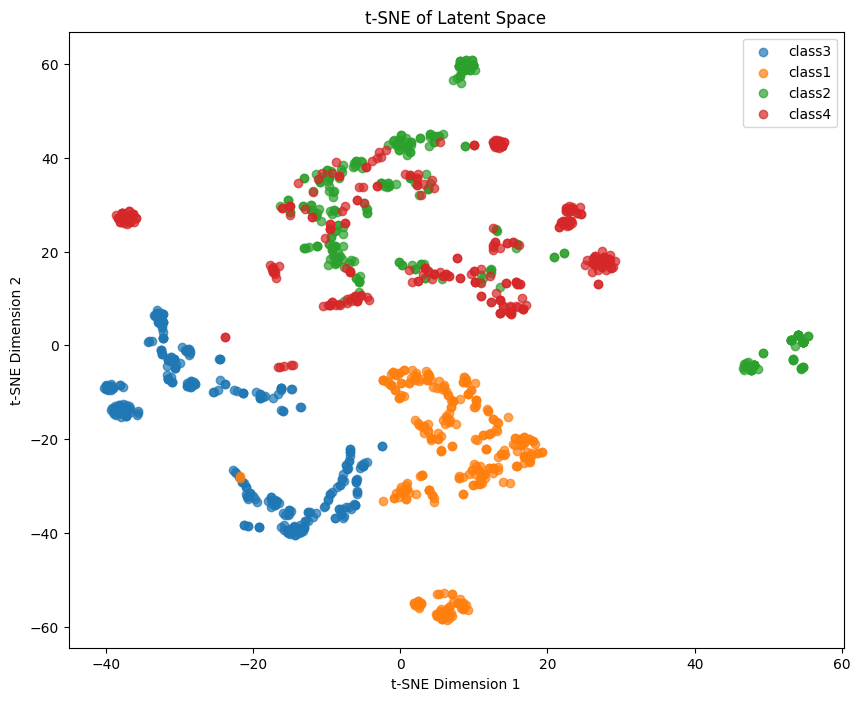

In [92]:
# t-SNE로 2차원 축소
tsne = TSNE(n_components=2)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

# t-SNE 결과 시각화
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(latent_vectors_2d[indices, 0], latent_vectors_2d[indices, 1], label=label_map[label], alpha=0.7)
plt.legend()
plt.title('t-SNE of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()